In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from collections import defaultdict
import random


In [2]:
# 构建简化树结构（2层）
#         0
#      /  |  \
#     1   2   3       ← 中间层
#    / \     / \
#   4  5    6  7      ← 叶子节点（物品）

tree = {
    0: [1, 2, 3],
    1: [4, 5],
    2: [],
    3: [6, 7]
}

intermediate_nodes = [0, 1, 2, 3]
leaf_nodes = [4, 5, 6, 7]
all_nodes = intermediate_nodes + leaf_nodes


In [3]:
# 模拟用户点击的叶子节点（用户兴趣）
user_leaf_clicks = {
    0: [4],
    1: [6],
    2: [5, 7]
}
num_users = len(user_leaf_clicks)


In [4]:
def get_positive_path(leaf_id):
    path = []
    for parent, children in tree.items():
        if leaf_id in children:
            path.append(parent)
            break
    path.append(leaf_id)
    return [0] + path  # 包括根节点

train_samples = []
for uid, leaves in user_leaf_clicks.items():
    for leaf in leaves:
        pos_nodes = set(get_positive_path(leaf))
        for nid in all_nodes:
            label = 1 if nid in pos_nodes else 0
            train_samples.append((uid, nid, label))

print(f"训练样本共 {len(train_samples)} 条")


训练样本共 32 条


In [7]:
class TDMModel(nn.Module):
    def __init__(self, num_users, num_nodes, embed_dim=16):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.node_embedding = nn.Embedding(num_nodes, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user_ids, node_ids):
        u = self.user_embedding(user_ids)
        n = self.node_embedding(node_ids)
        x = torch.cat([u, n], dim=-1)
        logits = self.mlp(x).view(-1)
        return logits


In [8]:
model = TDMModel(num_users=num_users, num_nodes=len(all_nodes))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

EPOCHS = 50
for epoch in range(EPOCHS):
    total_loss = 0
    random.shuffle(train_samples)
    for uid, nid, label in train_samples:
        user_ids = torch.tensor([uid])
        node_ids = torch.tensor([nid])
        labels = torch.tensor([label], dtype=torch.float)

        logits = model(user_ids, node_ids)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {total_loss:.4f}")


Epoch 0 Loss: 25.9402
Epoch 10 Loss: 8.6024
Epoch 20 Loss: 6.3062
Epoch 30 Loss: 5.6880
Epoch 40 Loss: 5.7285


In [9]:
def infer_leaf(user_id):
    current_node = 0  # start at root
    while current_node not in leaf_nodes:
        children = tree.get(current_node, [])
        if not children:
            break
        scores = []
        for child in children:
            uid_tensor = torch.tensor([user_id])
            nid_tensor = torch.tensor([child])
            score = model(uid_tensor, nid_tensor).item()
            scores.append((child, score))
        scores.sort(key=lambda x: -x[1])
        current_node = scores[0][0]  # greedy pick
    return current_node


In [10]:
for uid in range(num_users):
    pred_leaf = infer_leaf(uid)
    print(f"用户 {uid} 推荐物品（叶子节点）: {pred_leaf}，真实点击: {user_leaf_clicks[uid]}")


用户 0 推荐物品（叶子节点）: 4，真实点击: [4]
用户 1 推荐物品（叶子节点）: 6，真实点击: [6]
用户 2 推荐物品（叶子节点）: 7，真实点击: [5, 7]


In [11]:
def beam_search(user_id, beam_width=2, max_depth=2):
    # 初始化 beam：每条路径是 (路径节点列表, 累积得分)
    beam = [([0], 0.0)]  # 从根节点开始，得分为0

    for _ in range(max_depth):
        new_beam = []
        for path, score in beam:
            last_node = path[-1]
            children = tree.get(last_node, [])
            if not children:
                new_beam.append((path, score))  # 无子节点直接保留
                continue
            for child in children:
                uid_tensor = torch.tensor([user_id])
                nid_tensor = torch.tensor([child])
                pred_score = model(uid_tensor, nid_tensor).item()
                new_path = path + [child]
                new_beam.append((new_path, score + pred_score))
        # 选出得分 Top-k 的路径
        new_beam.sort(key=lambda x: -x[1])
        beam = new_beam[:beam_width]
    return beam


In [12]:
for uid in range(num_users):
    paths = beam_search(uid, beam_width=2, max_depth=2)
    print(f"用户 {uid} 推荐路径（Beam Search）：")
    for path, score in paths:
        print(f"  路径: {path}, 得分: {score:.4f}")


用户 0 推荐路径（Beam Search）：
  路径: [0, 1, 4], 得分: 17.7655
  路径: [0, 1, 5], 得分: 3.2470
用户 1 推荐路径（Beam Search）：
  路径: [0, 3, 6], 得分: 13.7116
  路径: [0, 3, 7], 得分: -2.1960
用户 2 推荐路径（Beam Search）：
  路径: [0, 1, 5], 得分: 0.1235
  路径: [0, 3, 7], 得分: 0.1188


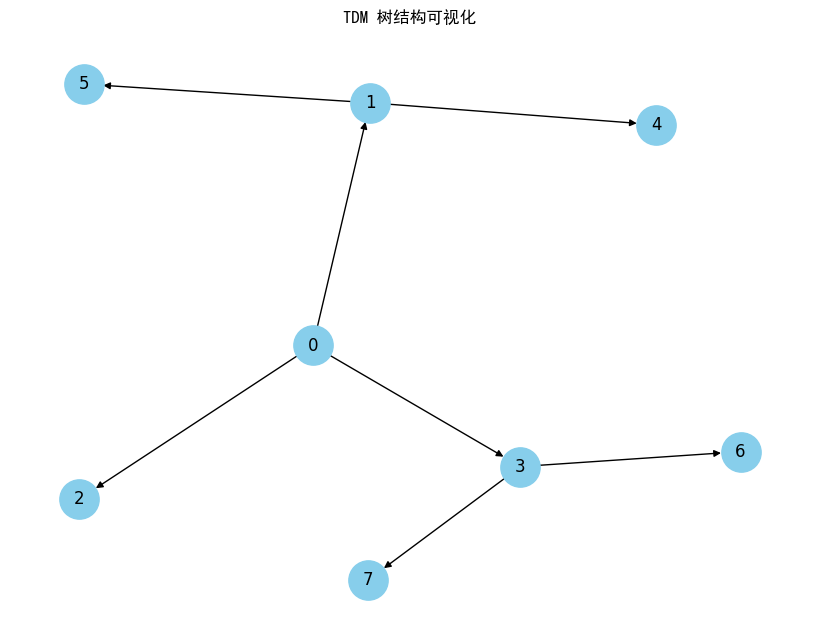

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
# 构造图
G = nx.DiGraph()
for parent, children in tree.items():
    for child in children:
        G.add_edge(parent, child)

# 简化版布局（兼容性强）
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, arrows=True, node_color='skyblue', node_size=800, font_size=12)
plt.title("TDM 树结构可视化")
plt.show()
